# Predicción de Respuesta a una Campaña de Marketing

## Introducción
El presente dataset para la **Predicción de Respuesta a una Campaña de Marketing** es un conjunto de datos que simula un escenario de marketing directo, donde una empresa se comunica con clientes potenciales seleccionados previamente. El objetivo es identificar qué clientes tienen más probabilidades de responder positivamente a una campaña de marketing. El dataset incluye información demográfica y financiera de los clientes, como la edad, el puntaje de crédito, el estado civil, el tipo de residencia, los ingresos, la propiedad de vehículos, la historia crediticia, el historial de pagos y el estado de empleo.

La variable objetivo es **"resp"**, que es binaria e indica si un cliente respondió (1) o no (0) a la campaña. El análisis se centrará en identificar patrones en las características de los clientes que estén correlacionados con una mayor probabilidad de respuesta.

## Hipótesis
Es posible predecir con precisión la probabilidad de que un cliente responda a una campaña de marketing directo utilizando sus características demográficas, financieras y residenciales, así como su historial de crédito y comportamiento con la empresa.

## Objetivo
El objetivo de este proyecto es analizar los factores que influyen en la respuesta de los clientes a una campaña de marketing directo y, a partir de este análisis, desarrollar un modelo de aprendizaje automático que pueda predecir la probabilidad de que un cliente responda positivamente a la campaña.

### Preguntas clave a responder:

- ¿Qué características de los clientes están más correlacionadas con la probabilidad de respuesta?
- ¿Cómo afectan las variables demográficas y financieras a la respuesta de los clientes?
- ¿Es posible mejorar la eficiencia de las campañas de marketing directo mediante un modelo predictivo que identifique a los clientes más propensos a responder?


## Análisis de los datos
### Instalacion e importación de las librerías requeridas

In [176]:
!pip install imbalanced-learn

In [177]:
!pip install xgboost

In [178]:
import pandas as pd
import numpy as np
import time
import matplotlib as plt
import matplotlib.pyplot as pyp
import plotly.express as px
from plotly.subplots import make_subplots
from math import pi
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE


### Lectura del dataset

In [179]:
df = pd.read_csv('https://raw.githubusercontent.com/garcia-damian/direct-mail-marketing/main/DirectMail.txt', sep='\t', engine='python')
df.head()

AGE   CRED MS  HEQ  INCOME DEPC MOB  MILEAGE RESTYPE GENDER  ... resp  \
0   20  543.0  U  0.1      20    N   Y   14.418    HOME      M  ...    0   
1   18  445.0  U  0.1      20    N   Y    0.311    HOME      M  ...    0   
2   19  423.0  U  0.1      20    N   N   17.876    HOME      M  ...    0   
3   18  416.0  X  0.1      20    N   Y   17.084    HOME      F  ...    0   
4   18  522.0  U  0.1      20    Y   Y   16.510    HOME      F  ...    0   

  female  HOME  CONDO COOP  renter  emp1  emp2  msn  cuscode  
0      0     1      0    0       1     1     0    0        1  
1      0     1      0    0       1     0     0    0        2  
2      0     1      0    0       1     1     0    0        3  
3      1     1      0    0       1     1     0    0        4  
4      1     1      0    0       1     1     0    0        5  

[5 rows x 26 columns]

### Descripción de las columnas del dataset

- **AGE**: Edad del cliente (en años).
- **CRED**: Puntaje de crédito del cliente.
- **MS**: Estado civil (la codificación específica no está proporcionada, pero probablemente representa diferentes estados civiles).
- **HEQ**: Equidad en el hogar como porcentaje.
- **INCOME**: Ingreso del cliente (posiblemente en miles u otra unidad, pero no especificado).
- **DEPC**: Indicador de depreciación (Y/N), probablemente indica si el cliente tiene un activo que se deprecia.
- **MOB**: Indicador de cliente existente (Y/N), indica si la persona es un cliente actual.
- **MILEAGE**: Kilometraje del automóvil, posiblemente representando el kilometraje del vehículo del cliente.
- **RESTYPE**: Tipo de residencia, probablemente categorizando el tipo de residencia (por ejemplo, CASA, CONDOMINIO, etc.).
- **GENDER**: Género del cliente (M para Masculino, F para Femenino).
- **EMP_STA**: Estado del empleo, posiblemente indicando diferentes tipos o condiciones de empleo. Puede tomar tres valores: "0", "1,2" o "3+".
- **RES_STA**: Estado residencial, probablemente reflejando la estabilidad o el tipo de residencia.
- **DELINQ**: Estado de morosidad, indicando si el cliente tiene un historial de morosidad (por ejemplo, pagos atrasados).
- **NUMTR**: Número de operaciones activas, posiblemente representando el número de líneas de crédito o operaciones activas.
- **MRTGI**: Indicador de hipoteca (Y/N), indica si el cliente tiene una hipoteca.
- **MFDU**: Indicador de Unidad de Vivienda Multifamiliar, posiblemente indicando si el cliente vive en una unidad multifamiliar.
- **resp**: Indicador de respuesta (Y/N), indicando si el cliente respondió a una campaña de marketing.
- **female**: Indicador femenino, una bandera binaria que parece redundante dado que existe la columna GENDER.
- **HOME**: Indicador de propiedad (Y/N), muestra si el cliente es propietario de una casa.
- **CONDO**: Indicador de condominio (Y/N), indica si el cliente vive en un condominio.
- **COOP**: Indicador de cooperativa (Y/N), indica si el cliente vive en una unidad de vivienda cooperativa.
- **renter**: Indicador de alquiler de vivienda (Y/N), indica si el cliente alquila su residencia.
- **emp1**: Variable booleana indicando si EMP_STA es igual a "1,2".
- **emp2**: Variable booleana indicando si EMP_STA es igual a "3+".
- **msn**: Programa de Red de Seguridad Médica (Y/N), indicando si el cliente forma parte de un programa de red de seguridad médica.
- **cuscode**: Código de identificación del cliente, un identificador único para cada cliente.

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29904 entries, 0 to 29903
Data columns (total 26 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AGE      29904 non-null  int64  
 1   CRED     29871 non-null  float64
 2   MS       29904 non-null  object 
 3   HEQ      29904 non-null  float64
 4   INCOME   29904 non-null  int64  
 5   DEPC     29904 non-null  object 
 6   MOB      29904 non-null  object 
 7   MILEAGE  29904 non-null  float64
 8   RESTYPE  29904 non-null  object 
 9   GENDER   29904 non-null  object 
 10  EMP_STA  29904 non-null  object 
 11  RES_STA  29904 non-null  object 
 12  DELINQ   29904 non-null  int64  
 13  NUMTR    29904 non-null  int64  
 14  MRTGI    29904 non-null  object 
 15  MFDU     29904 non-null  int64  
 16  resp     29904 non-null  int64  
 17  female   29904 non-null  int64  
 18  HOME     29904 non-null  int64  
 19  CONDO    29904 non-null  int64  
 20  COOP     29904 non-null  int64  
 21  renter   299

### Data Wrangling
#### Eliminación de posibles duplicados
Se comprueba que no haya registros duplicados y se eliminan en caso de que sí.

In [181]:
print(df.shape)
df= df.drop_duplicates()
print(df.shape)

(29904, 26)
(29904, 26)


#### Columnas redundantes y sin valor agregado
- La columna 'renter' tiene un valor constante para todos los registros del dataset, por lo que no aporta ningún valor.
- La columna 'female' es redundante con la columna 'GENDER', pero dado que female es binaria y GENDER es categórica, eliminaremos la segunda.
- La columna 'cuscode' es un id y no aporta ningún valor al análisis, por lo que será eliminada.
- Si bien las columnas 'HOME', 'CONDO' y 'COOP' parecen ser redundantes con la columna 'RESTYPE', por lo que serán eliminadas.
- Lo mismo sucede entre las columnas 'emp1' y 'emp2' con respecto a la columna 'EMP_STA'.

In [182]:
df.drop(columns=['renter', 'GENDER', 'cuscode', 'HOME', 'CONDO', 'COOP', 'emp1', 'emp2'], inplace=True)
df.head()

AGE   CRED MS  HEQ  INCOME DEPC MOB  MILEAGE RESTYPE EMP_STA RES_STA  \
0   20  543.0  U  0.1      20    N   Y   14.418    HOME     1,2     1,2   
1   18  445.0  U  0.1      20    N   Y    0.311    HOME       0     1,2   
2   19  423.0  U  0.1      20    N   N   17.876    HOME     1,2     1,2   
3   18  416.0  X  0.1      20    N   Y   17.084    HOME     1,2     1,2   
4   18  522.0  U  0.1      20    Y   Y   16.510    HOME     1,2     1,2   

   DELINQ  NUMTR MRTGI  MFDU  resp  female  msn  
0       0      2     N     0     0       0    0  
1       2      2     Y     0     0       0    0  
2       1      0     Y     0     0       0    0  
3       0      0     Y     0     0       1    0  
4       1      0     Y     0     0       1    0

#### Tratamiento de nulos

In [183]:
df.isnull().sum()

AGE         0
CRED       33
MS          0
HEQ         0
INCOME      0
DEPC        0
MOB         0
MILEAGE     0
RESTYPE     0
EMP_STA     0
RES_STA     0
DELINQ      0
NUMTR       0
MRTGI       0
MFDU        0
resp        0
female      0
msn         0
dtype: int64

Dado que sólo hay 33 registros de los cuales no se conoce el puntaje crediticio del cliente, se imputará este valor con el promedio del dataset.

In [184]:
df['CRED'].fillna(df['CRED'].mean(), inplace=True)

C:\Users\thega\AppData\Local\Temp\ipykernel_28188\2173264618.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





#### Nombres y tipos de columnas
Por último, se renombrarán las columnas con nombres más representativos y se asignarán los tipos de datos correspondientes.

In [185]:
df = df.rename(columns={
    'AGE': 'Age',
    'CRED': 'CreditScore',
    'MS': 'MaritalStatus',
    'HEQ': 'HomeEquity',
    'INCOME': 'Income',
    'DEPC': 'Depreciation',
    'MOB': 'IsExistingCustomer',
    'MILEAGE': 'CarMileage',
    'RESTYPE': 'RealEstateType',
    'female': 'Female',
    'EMP_STA': 'EmploymentStatus',
    'RES_STA': 'ResidentialStatus',
    'DELINQ': 'DelinquencyStatus',
    'NUMTR': 'ActiveTrades',
    'MRTGI': 'Mortgage',
    'resp': 'Response',
    'msn': 'MedicalProgram'
})
df['Age'] = df['Age'].astype('int8')
df['MaritalStatus'] = df['MaritalStatus'].astype('category')
df['Depreciation'] = df['Depreciation'].map({'Y': 1, 'N': 0}).astype('int8')
df['IsExistingCustomer'] = df['IsExistingCustomer'].map({'Y': 1, 'N': 0}).astype('int8')
df['RealEstateType'] = df['RealEstateType'].astype('category')
df['Female'] = df['Female'].astype('int8')
df['EmploymentStatus'] = df['EmploymentStatus'].astype('category')
df['ResidentialStatus'] = df['ResidentialStatus'].astype('category')
df['Mortgage'] = df['Mortgage'].astype('category')
df['MedicalProgram'] = df['MedicalProgram'].astype('int8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29904 entries, 0 to 29903
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 29904 non-null  int8    
 1   CreditScore         29904 non-null  float64 
 2   MaritalStatus       29904 non-null  category
 3   HomeEquity          29904 non-null  float64 
 4   Income              29904 non-null  int64   
 5   Depreciation        29904 non-null  int8    
 6   IsExistingCustomer  29904 non-null  int8    
 7   CarMileage          29904 non-null  float64 
 8   RealEstateType      29904 non-null  category
 9   EmploymentStatus    29904 non-null  category
 10  ResidentialStatus   29904 non-null  category
 11  DelinquencyStatus   29904 non-null  int64   
 12  ActiveTrades        29904 non-null  int64   
 13  Mortgage            29904 non-null  category
 14  MFDU                29904 non-null  int64   
 15  Response            29904 non-null  

Considerando que la columna ResidentialStatus sólo tiene dos posibles valores ['1,2' , '3+'], podemos transformarla a una columna binaria llamada ResidentialStatus+3

In [186]:
print(df['ResidentialStatus'].value_counts())
df['ResidentialStatus+3'] = (df['ResidentialStatus'] == '3+').astype('int8')
print(df['ResidentialStatus+3'].value_counts())
df.drop('ResidentialStatus', axis=1, inplace=True)
df.reset_index(inplace=True, drop=True)

ResidentialStatus
1,2    28109
3+      1795
Name: count, dtype: int64
ResidentialStatus+3
0    28109
1     1795
Name: count, dtype: int64


In [187]:
df.describe()

Age   CreditScore    HomeEquity        Income  Depreciation  \
count  29904.000000  29904.000000  29904.000000  29904.000000  29904.000000   
mean      49.300361    603.627364     38.328892     41.360688      0.381287   
std       15.546298     98.082496     37.205701     15.441137      0.485711   
min       18.000000    300.000000      0.100000     20.000000      0.000000   
25%       36.000000    574.000000     10.000000     30.000000      0.000000   
50%       50.000000    617.000000     30.000000     40.000000      0.000000   
75%       61.000000    652.000000     50.000000     50.000000      1.000000   
max       90.000000   1789.000000    200.000000    110.000000      1.000000   

       IsExistingCustomer    CarMileage  DelinquencyStatus  ActiveTrades  \
count        29904.000000  29904.000000       29904.000000  29904.000000   
mean             0.620787     11.803395           0.766152      0.763343   
std              0.485199      5.744523           1.140847      1.143284   
min              0.000000      0.000000           0.000000      0.000000   
25%              0.000000      7.775750           0.000000      0.000000   
50%              1.000000     12.536500           0.000000      0.000000   
75%              1.000000     16.193250           1.000000      1.000000   
max              1.000000     94.640000           7.000000      7.000000   

               MFDU      Response        Female  MedicalProgram  \
count  29904.000000  29904.000000  29904.000000    29904.000000   
mean       0.452749      0.095539      0.422285        0.575876   
std        0.497771      0.293963      0.493932        0.494218   
min        0.000000      0.000000      0.000000        0.000000   
25%        0.000000      0.000000      0.000000        0.000000   
50%        0.000000      0.000000      0.000000        1.000000   
75%        1.000000      0.000000      1.000000        1.000000   
max        1.000000      1.000000      1.000000        1.000000   

       ResidentialStatus+3  
count         29904.000000  
mean              0.060025  
std               0.237538  
min               0.000000  
25%               0.000000  
50%               0.000000  
75%               0.000000  
max               1.000000

### Visualización de los datos
#### Distribución de las edades de los clientes
El primer dato a analizar es la distribución de edades y género de los clientes. La distribución es algo peculiar, con un extraño valle entre los 30 y los 50 años. A nivel de género, parece estar distribuida  de forma pareja.

In [188]:
px.histogram(df, x='Age', color='Female', title='Distribución de los clientes por edad y género')

Extrañamente, la columna HomeEquity no tiene ningún valor 100% y en su lugar tiene muchos registros con 200%, lo cual no tiene sentido, por lo que haremos la corrección.

In [189]:
# Reemplazar todos los valores 200 por 100 en la columna HomeEquity
df['HomeEquity'] = df['HomeEquity'].replace(200, 100)
print(df['HomeEquity'].describe())
fig = px.violin(df, y='HomeEquity', title='Violin plot del HomeEquity')
fig.update_layout(yaxis_title="HomeEquity (%)")

count    29904.000000
mean        35.322606
std         26.528719
min          0.100000
25%         10.000000
50%         30.000000
75%         50.000000
max        100.000000
Name: HomeEquity, dtype: float64


#### Análisis del puntaje crediticio de los clientes

In [190]:
px.box(df, y='CreditScore', points='all', color='Female', title='Boxplot de CreditScore según género')

Los valores de CreditScore por encima de 1000 parecen un error ya que son un valor muy específico y son muy pocos casos. Los reemplazaremos con el valor máximo 1000.

In [191]:
# Reemplazar valores mayores a 1000 en la columna CreditScore por 1000
df['CreditScore'] = df['CreditScore'].apply(lambda x: 1000 if x > 1000 else x)
print(df['CreditScore'].describe())
px.box(df, y='CreditScore', points='all', color='Female', title='Boxplot de CreditScore según género')

count    29904.000000
mean       603.205213
std         94.616280
min        300.000000
25%        574.000000
50%        617.000000
75%        652.000000
max       1000.000000
Name: CreditScore, dtype: float64


#### Distribución del millaje de los vehículos de los clientes discriminados por género
La gran mayoría de los clientes (tanto hombres como mujeres) parecen tener vehículos con menos de 20.000 millas de rodaje.

In [192]:
fig = px.box(df, 
             y='CarMileage', 
             points='all', 
             color='Female', 
             title='Boxplot de CarMileage según género')

fig.update_layout(
    yaxis_title="Car Mileage (thousands of miles)"  
)

fig.show()

#### Distribución de clientes existentes
Un 62% de los clientes ya ha realizado compras previas

In [193]:
fig = px.pie(df, 
             names='IsExistingCustomer',    
             title="Distribución de Clientes Existentes",  
             hole=0.3)  

fig.show()

#### Distribución de clientes que tienen hipotecas a su nombre
Aproximadamente un tercio de los clientes tienen hipotecas a su nombre.

In [194]:
fig = px.pie(df, 
             names='Mortgage',    
             title="Distribución de Mortgage",  
             hole=0.3)  

fig.show()

#### Histograma de respuestas positivas discriminadas por género
Ahora vamos a centrarnos en los clientes que respondieron positivamente a la campaña de email marketing. Primero realizaremos un histograma de sus edades discriminadas por género. La mayoría se encuentran entre los 25 y los 30 años, o entre los 50 y los 65.

In [195]:
px.histogram(df, x='Age', y='Response', color='Female', title='Distribución de respuestas positivas según edad y género')

#### Distribución de clientes según su tipo de vivienda, discriminados por respuesta a la campaña
La gran mayoría de los clientes viven en casas, tanto propias como alquiladas.

In [196]:
px.histogram(df, x='RealEstateType', color='Response', title='Distribución de las respuestas por RealEstateType')

#### Distribución de clientes por estado civil, discriminados por respuesta a la campaña

Luego de las transformaciones realizadas, los valores de la columna MaritalStatus son:

- 1: Married (casado)
- 0: Unmarried (Soltero)

In [197]:
px.histogram(df, x='MaritalStatus', color='Response', title='Distribución de las respuestas por Married')

#### Distribución de la cantidad de líneas de crédito activas por usuario en relación a su respuesta a la campaña
Los clientes que respondieron a la campaña parecen tener una leve tendencia a tener más líneas de crédito activas que los que no respondieron.

In [198]:
px.box(df, y='ActiveTrades', color='Response', title='Boxplot de ActiveTrades discriminados por tipo de respuesta')



#### Scatterplot de los usuarios que respondieron a la campaña, en relación a sus ingresos y su puntaje crediticio
La mayor concentración de clientes que respondieron a la campaña parece tener un ingreso anual entre los 20 y los 50 mil dólares y un puntaje crediticio que va desde los 550 hasta los 680 puntos

In [199]:
# Agrupamos los datos por 'Income' y 'CreditScore' y contamos las respuestas positivas
df_grouped = df[df['Response'] == 1].groupby(['Income', 'CreditScore']).size().reset_index(name='Response')

fig = px.scatter(df_grouped, 
                 y="Income", 
                 x="CreditScore",
                 size="Response",     
                 size_max=30,            
                 opacity=0.3,                          
                 )         
fig.update_layout(
    title="Distribución de respuestas positivas según Income y CreditScore",
    yaxis_title="Income (thousands of dollars per year)"  
)

# Eliminamos el borde blanco de las burbujas
fig.update_traces(marker=dict(line=dict(width=0)))   
fig.show()

#### Scatterplot de los usuarios que respondieron a la campaña en relación a su registro de delitos y el millaje de su vehículo
Otras dos variables interesantes a analizar pueden ser el millaje de los vehículos y el registro delictivo de los clientes que respondieron a la campaña. La gran mayoría parece tener un registro delictivo menor o igual a 4 y vehículos con menos de 20 mil millas de rodaje.

In [200]:
# Agrupamos los datos por 'CarMileage' y 'DelinquencyStatus' y contamos las respuestas positivas
df_grouped = df[df['Response'] == 1].groupby(['CarMileage', 'DelinquencyStatus']).size().reset_index(name='Response')

fig = px.scatter(df_grouped, 
                 y="CarMileage", 
                 x="DelinquencyStatus",
                 size="Response",     
                 size_max=10,           
                 opacity=0.3,                           
                 )         
fig.update_layout(
    title="Distribución de respuestas positivas según CarMileage y DelinquencyStatus",
    yaxis_title="Car Mileage (thousands of miles)"  
)

# Eliminamos el borde blanco de las burbujas
fig.update_traces(marker=dict(line=dict(width=0)))   
fig.show()

In [201]:
df[df.select_dtypes(include=['object', 'category']).columns].head(5)

MaritalStatus RealEstateType EmploymentStatus Mortgage
0             U           HOME              1,2        N
1             U           HOME                0        Y
2             U           HOME              1,2        Y
3             X           HOME              1,2        Y
4             U           HOME              1,2        Y

In [202]:
df['EmploymentStatus'].value_counts()

EmploymentStatus
1,2    27146
3+      1790
0        968
Name: count, dtype: int64

In [203]:
df.shape

(29904, 18)

### Matriz de correlación

Finalmente, evaluaremos la correlación lineal entre todas las variables del dataset con una matriz de correlación

In [204]:
df_encoded = None

In [205]:
# Codificación ordinal para 'EmploymentStatus'
ordinal_encoder = OrdinalEncoder(categories=[['0', '1,2', '3+']])  # Define el orden
df['EmploymentStatus_encoded'] = ordinal_encoder.fit_transform(df[['EmploymentStatus']])

# Codificación One-Hot para 'RealEstateType'
onehot_encoder = OneHotEncoder(sparse_output=False)  # Cambiado a sparse_output
onehot_encoded_cols = onehot_encoder.fit_transform(df[['RealEstateType', 'MaritalStatus', 'Mortgage']])
onehot_encoded_df = pd.DataFrame(onehot_encoded_cols, columns=onehot_encoder.get_feature_names_out(['RealEstateType', 'MaritalStatus', 'Mortgage']))

# Concatenar las columnas codificadas al DataFrame original
df_encoded = pd.concat([df, onehot_encoded_df], axis=1)

# Seleccionar solo las columnas codificadas y eliminar las originales
df_encoded = df_encoded.drop(['EmploymentStatus', 'RealEstateType', 'MaritalStatus', 'Mortgage'], axis=1)

# Cálculo de la matriz de correlación
corr_matrix = df_encoded.corr()
print(corr_matrix)

# Visualización con Plotly
fig = px.imshow(corr_matrix, 
                text_auto=True, 
                labels=dict(color="Correlación"),
                color_continuous_scale="RdBu",
                range_color=[-1, 1],
                x=corr_matrix.columns,
                y=corr_matrix.columns)

# Ajustes de tamaño y orientación de las etiquetas
fig.update_layout(
    title="Matriz de Correlación",
    width=800,  
    height=800,  
    xaxis=dict(tickangle=-45),  
    yaxis=dict(tickmode='linear')  
)

fig.show()




                               Age  CreditScore  HomeEquity    Income  \
Age                       1.000000     0.194187    0.241509  0.050044   
CreditScore               0.194187     1.000000    0.063622  0.019443   
HomeEquity                0.241509     0.063622    1.000000 -0.005728   
Income                    0.050044     0.019443   -0.005728  1.000000   
Depreciation              0.005754     0.001696   -0.011134 -0.000199   
IsExistingCustomer       -0.009979     0.005545   -0.002690 -0.004463   
CarMileage               -0.002332    -0.004864   -0.009735  0.003891   
DelinquencyStatus        -0.001819    -0.000699   -0.000113 -0.009672   
ActiveTrades              0.001631     0.006058   -0.001110  0.008713   
MFDU                      0.005576     0.003500    0.008285  0.001426   
Response                 -0.030991    -0.024384   -0.005178 -0.041534   
Female                   -0.006071     0.007157    0.002339  0.000163   
MedicalProgram            0.018853     0.005254    

## Conclusiones y próximos pasos
A pesar de que el análisis exploratorio de datos no muestra correlaciones lineales fuertes entre la variable objetivo y las variables independientes, los resultados sugieren que la campaña de marketing tiene una mayor probabilidad de generar respuestas positivas en personas pertenecientes a ciertos segmentos. En particular, los individuos en determinadas franjas etarias, que viven en viviendas (ya sean de su propiedad o alquiladas), con un puntaje crediticio en el rango de 550 a 680 puntos, y con un ingreso anual entre 20.000 y 50.000 dólares, tienden a responder de manera más favorable a las campañas. Esto implica que ciertos factores demográficos y financieros pueden desempeñar un papel crucial en la efectividad de las campañas dirigidas.

Además, se detecta que los usuarios con un puntaje de delincuencia menor a 5, aquellos que están casados (MaritalStatus = M), y los que mantienen varias líneas de crédito activas (ActiveTrades) presentan una mayor propensión a participar y responder positivamente a las acciones de marketing, en comparación con aquellos que no comparten estas características. 

Sin embargo, se destaca un problema significativo en el conjunto de datos: existe un desbalance considerable en la distribución de la variable objetivo, con menos del 10% de las respuestas siendo positivas. 

De cara al futuro, es esencial abordar este desequilibrio antes de implementar modelos predictivos. Una posible estrategia sería el uso de técnicas de remuestreo, como undersampling de la clase mayoritaria, para equilibrar la distribución de las respuestas. Otra opción sería la implementación de algoritmos de clasificación robustos frente a datasets desbalanceados, tales como XGBoost o Random Forest con pesos ajustados para las clases. Además, se podría aplicar un enfoque basado en la optimización de métricas específicas para datasets desbalanceados, como el F1-score, que balancea precisión y sensibilidad.

En cuanto a los modelos predictivos, una opción viable es desarrollar una serie de modelos de clasificación, como regresión logística, árboles de decisión, o redes neuronales, para predecir la probabilidad de una respuesta positiva. Estos modelos pueden ajustarse para mejorar su rendimiento en un entorno de datos desbalanceados. También es recomendable realizar una validación cruzada y utilizar métricas como ROC-AUC y la curva Precision-Recall, para evaluar el desempeño de los modelos de forma más robusta.

Finalmente, implementar un modelo de regresión logística podría ser especialmente útil para entender mejor la relación entre las variables explicativas y la probabilidad de respuesta, dado que este tipo de modelo no solo proporciona predicciones, sino también coeficientes interpretables que permiten identificar cuáles son los factores más influyentes en la decisión de responder positivamente a la campaña de marketing. Con base en estos resultados, la empresa podría ajustar sus estrategias de marketing, focalizando sus esfuerzos en los segmentos de clientes con mayor probabilidad de responder favorablemente, optimizando así el uso de recursos y maximizando el retorno de la inversión.

## Reducción de Dimensionalidad
   ### Implementación de PCA      
Análisis de Varianza Explicada y Selección de Componentes Principales

In [206]:
# Estandarización del DataFrame original (excluyendo columnas no numéricas o etiquetas)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded.drop('Response', axis=1))  # Suponiendo que 'Response' es la etiqueta

# Aplicación de PCA
pca = PCA()
pca_df = pca.fit_transform(df_scaled)

# Varianza explicada acumulada
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Encuentra el número de componentes necesarios para capturar el 95% de la varianza
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Número de componentes para capturar el 95% de la varianza: {n_components_95}")

# Crear DataFrame para graficar
components_df = pd.DataFrame({
    'Número de Componentes': range(1, len(cumulative_variance) + 1),
    'Varianza Acumulada': cumulative_variance
})

# Graficar con Plotly Express
fig = px.line(
    components_df, 
    x='Número de Componentes', 
    y='Varianza Acumulada', 
    title="Varianza Acumulada por Número de Componentes",
    markers=True
)

# Ajustar etiquetas y añadir una línea de referencia para el 95%
fig.update_layout(
    xaxis_title="Número de Componentes",
    yaxis_title="Varianza Acumulada",
    showlegend=False
)
fig.add_hline(
    y=0.95, 
    line_dash="dot",
    annotation_text="95% de Varianza", 
    annotation_position="bottom right"
)

# Mostrar el gráfico
fig.show()




Número de componentes para capturar el 95% de la varianza: 18


Este análisis nos muestra que para capturar el 95% de la varianza necesitamos al menos 16 componentes de PCA, que es la misma cantidad de variables independientes que hay en nuestro dataset original, por lo que no se vislumbra un beneficio al intentar una reducción de la dimensionalidad.

En resumen, necesitamos al menos 13 dimensiones de PCA para representar el 80% de la varianza. Esto no dista mucho de las 18 dimensiones originales del dataset y, dado que el conjunto de datos es chico (menos de 30.000 registros), no considero relevante el impacto en la performance de los modelos que pueda tener una posible reducción de la dimensionalidad.

## Entrenamiento y Testing de Modelos
En lugar de entrenar los modelos por separado, realizaremos un proceso iterativo. Dentro de cada iteración optimizaremos los parámetros para el modelo en cuestión, validaremos el modelo y guardaremos las métricas de performance del mismo para futuro análisis

### Definición de modelos y parámetros
A continuación definiremos los modelos que vamos a evaluar y comparar. Algunas consideraciones a tener en cuenta:

**Optimización de parámetros**

Antes de entrenar cada modelo utilizaremos GridSearch para encontrar su configuración óptima. Las opciones con las que configuro GridSearch en cada caso han sido preseleccionadas luego de un análisis más extenso que no se encuentra detallado en el código, ya que tomaría mucho tiempo de procesamiento.

**Oversampling con SMOTE**

Como tenemos un dataset muy desbalanceado, haremos un oversampling de la clase minoritaria. La estrategia de muestreo para cada modelo ha sido seleccionada por mí después de evaluar las métricas obtenidas para cada combinación. El método iterativo por el cual se consiguió la estrategia óptima para cada caso no se encuentra programada aquí porque tomaría demasiado tiempo de procesamiento. En su lugar, he reemplazado las mejores y se pueden ver en el código bajo el comentario ```## best sampling_strategies```

**Modelos de ensamble**

Los tres últimos modelos a evaluar son de ensamble: BalancedRandoForest (bagging) que es una variante de RandomForest particularmente útil para datasets desbalanceados, GradientBoost y XGBoost (ambos, métodos de boosting con un learning rate de 0.1)

In [207]:
# Definir modelos y parámetros a optimizar
models = {
    "LogisticRegression": (LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42), {
        'penalty': ['l2'],
        'C': [0.1, 1],
        'max_iter': [100, 200, 500, 1000]
    },[1.0]), ## best sampling_strategies
    "KNearestNeighbors": (KNeighborsClassifier(n_jobs=-1),{
        'n_neighbors': [2, 3, 5],
        'weights': ['uniform', 'distance']
    },[0.5]), ## best sampling_strategies
    "BalancedRandomForest": (BalancedRandomForestClassifier(random_state=42, n_jobs=-1), {
        "n_estimators": [100, 200, 500],       
        "max_depth": [40, 80]    
    },["none"]), ## best sampling_strategies
    "GradientBoostClassifier": (GradientBoostingClassifier(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.2],
        'max_depth': [3, 4, 5]
    }, [1.0]),
    "XGBoost": (XGBClassifier(eval_metric="logloss", n_jobs=-1, random_state=42, learning_rate=0.1), {
        "n_estimators": [1000, 2000], 
        "max_depth": [3, 10, 20]
    },[1.0]) ## best sampling_strategies
}

#### Validación de los modelos
Para la validación de cada modelo utilizamos Stratified K-Fold Validation. Entrenaremos el modelo con 5 muestras distintas y las métricas de performance que utilizaremos son un promedio de las métricas obtenidas en esas 5 iteraciones para cada modelo.

In [208]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

#### Entrenamiento y recolección de métricas de performance
Para cada modelo a evaluar realizremos el siguiente proceso:
  - Crear diferentes conjuntos de train/test para validar el modelo con Stratified K-Folds Validation
  - Resamplear cada conjunto de datos aplicando oversampling en caso de que el modelo a entrenar así lo requiera
  - Escalar los datos para optimizar la performance del modelo
  - Optimizar los parámetros de configuración del modelo con GridSearch
  - Entrnar el modelo con los parámetros obtenidos
  - Ejecutar predicciones y almacenar métricas de performance

In [209]:
# Función para calcular la especificidad
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Dividir los datos
X = df_encoded.drop(columns=["Response"])
y = df_encoded["Response"]

# Inicializar lista para almacenar métricas de performance
metrics_list = []

for model_name, (model, param_grid, sampling_strategies) in models.items():
    for sampling_strategy in sampling_strategies:

        # Métricas para K-Fold Cross-Validation
        fold_metrics = {
            "accuracy": [],
            "precision": [],
            "recall": [],
            "specificity": [],
            "f1_score": [],
            "roc_auc": [],
            "roc_curves": [],  # Almacenar las curvas ROC
            "training_time": [],
            "tp": [],
            "tn": [],
            "fp": [],
            "fn": []
        }

        # Preparar variables para almacenar las curvas ROC de cada pliegue
        tprs = []
        mean_fpr = np.linspace(0, 1, 100)  # Puntos comunes de FPR para interpolación
        
        for train_index, test_index in skf.split(X, y):
            # Dividir datos en entrenamiento y prueba para este pliegue
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                    
            # Crear SMOTE en base a las estrategias de muestreo definidas para cada modelo
            if sampling_strategy != "none":
                smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
            else:
                X_train_resampled, y_train_resampled = X_train, y_train
            
            # Escalar los datos
            X_train_scaled = scaler.fit_transform(X_train_resampled)
            X_test_scaled = scaler.transform(X_test)

            # GridSearch para obtener los mejores parámetros
            grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
            start_time = time.time()
            grid_search.fit(X_train_scaled, y_train_resampled)
            training_time = time.time() - start_time
            best_model = grid_search.best_estimator_

            # Predecir y calcular métricas
            y_pred = best_model.predict(X_test_scaled)
            y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, "predict_proba") else None

            # Calcular la matriz de confusión
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            
            # Guardar métricas
            fold_metrics["accuracy"].append(accuracy_score(y_test, y_pred))
            fold_metrics["precision"].append(precision_score(y_test, y_pred, zero_division=0))
            fold_metrics["recall"].append(recall_score(y_test, y_pred, zero_division=0))
            fold_metrics["specificity"].append(specificity(y_test, y_pred))
            fold_metrics["f1_score"].append(f1_score(y_test, y_pred, zero_division=0))
            if y_pred_proba is not None:
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                fold_metrics["roc_curves"].append((fpr, tpr))  # Almacenar la curva ROC
                fold_metrics["roc_auc"].append(roc_auc_score(y_test, y_pred_proba))
            else:
                fold_metrics["roc_auc"].append(None)  # No se puede calcular AUC si no hay probabilidades
            fold_metrics["training_time"].append(training_time)
            fold_metrics["tp"].append(tp)
            fold_metrics["tn"].append(tn)
            fold_metrics["fp"].append(fp)
            fold_metrics["fn"].append(fn)
        

            # Calcular curva ROC y guardar TPR interpolado
            if y_pred_proba is not None:
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                interp_tpr = np.interp(mean_fpr, fpr, tpr)  # Interpolar en mean_fpr
                interp_tpr[0] = 0.0  # Asegurar que TPR comienza en 0
                tprs.append(interp_tpr)
            
        # Promediar los TPR interpolados para obtener la curva ROC promedio
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0  # Asegurar que TPR termina en 1

        # Promediar las métricas de los pliegues
        metrics_list.append({
            "model": model_name,
            "sampling_strategy": sampling_strategy,
            "optimal_params": grid_search.best_params_,
            "accuracy": np.mean(fold_metrics["accuracy"]),
            "precision": np.mean(fold_metrics["precision"]),
            "recall": np.mean(fold_metrics["recall"]),
            "specificity": np.mean(fold_metrics["specificity"]),
            "f1_score": np.mean(fold_metrics["f1_score"]),
            "roc_curve": (mean_fpr, mean_tpr),  # Almacenar la curva ROC promedio
            "roc_auc": np.mean(fold_metrics["roc_auc"]),
            "avg_training_time": np.mean(fold_metrics["training_time"]),
            "tp": np.mean(fold_metrics["tp"]),
            "tn": np.mean(fold_metrics["tn"]),
            "fp": np.mean(fold_metrics["fp"]),
            "fn": np.mean(fold_metrics["fn"])
        })

# Convertir metrics_list en un DataFrame
metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)





c:\Users\thega\miniconda3\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning:

The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.

c:\Users\thega\miniconda3\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning:

The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.

c:\Users\thega\miniconda3\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning:

The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.

c:\Users\thega\miniconda3\Lib

                     model sampling_strategy  \
0       LogisticRegression               1.0   
1        KNearestNeighbors               0.5   
2     BalancedRandomForest              none   
3  GradientBoostClassifier               1.0   
4                  XGBoost               1.0   

                                      optimal_params  accuracy  precision  \
0         {'C': 1, 'max_iter': 100, 'penalty': 'l2'}  0.865503   0.147049   
1           {'n_neighbors': 2, 'weights': 'uniform'}  0.865068   0.117971   
2             {'max_depth': 40, 'n_estimators': 200}  0.568319   0.125379   
3  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...  0.892957   0.161068   
4            {'max_depth': 20, 'n_estimators': 1000}  0.889814   0.132809   

     recall  specificity  f1_score  \
0  0.084352     0.948017  0.107147   
1  0.063701     0.949717  0.082703   
2  0.588725     0.566162  0.206718   
3  0.028703     0.984250  0.048279   
4  0.028000     0.980848  0.046155   

                   

### Evaluación de Modelos
#### Información de las métricas obtenidas para cada modelo


In [210]:
metrics_df.nlargest(5, 'f1_score')

model sampling_strategy  \
2     BalancedRandomForest              none   
0       LogisticRegression               1.0   
1        KNearestNeighbors               0.5   
3  GradientBoostClassifier               1.0   
4                  XGBoost               1.0   

                                      optimal_params  accuracy  precision  \
2             {'max_depth': 40, 'n_estimators': 200}  0.568319   0.125379   
0         {'C': 1, 'max_iter': 100, 'penalty': 'l2'}  0.865503   0.147049   
1           {'n_neighbors': 2, 'weights': 'uniform'}  0.865068   0.117971   
3  {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...  0.892957   0.161068   
4            {'max_depth': 20, 'n_estimators': 1000}  0.889814   0.132809   

     recall  specificity  f1_score  \
2  0.588725     0.566162  0.206718   
0  0.084352     0.948017  0.107147   
1  0.063701     0.949717  0.082703   
3  0.028703     0.984250  0.048279   
4  0.028000     0.980848  0.046155   

                                           roc_curve   roc_auc  \
2  ([0.0, 0.010101010101010102, 0.020202020202020...  0.607866   
0  ([0.0, 0.010101010101010102, 0.020202020202020...  0.557731   
1  ([0.0, 0.010101010101010102, 0.020202020202020...  0.518368   
3  ([0.0, 0.010101010101010102, 0.020202020202020...  0.584202   
4  ([0.0, 0.010101010101010102, 0.020202020202020...  0.560496   

   avg_training_time          tp           tn           fp          fn  
2          12.076141  560.666667  5104.333333  3911.333333  391.666667  
0           3.963157   80.333333  8547.000000   468.666667  872.000000  
1           4.245827   60.666667  8562.333333   453.333333  891.666667  
3         110.386264   27.333333  8873.666667   142.000000  925.000000  
4          74.301770   26.666667  8843.000000   172.666667  925.666667

#### Matrices de confusión
A continuación analizaremos las matrices de confusión para cada modelo (las métricas son promedios obtenidos a partir de Stratified K-Fold Validation, por lo que serán números flotantes y no enteros). Cada modelo indica los parámetros ótimos con los que fue entrenado según el análisis realizado con GridSearch

In [211]:
# Definir el tamaño de la figura y el número de filas para el gráfico de 2 columnas
num_models = len(metrics_df)
num_cols = 2
num_rows = (num_models + num_cols - 1) // num_cols

# Crear subplots con títulos y configurar el tamaño de fuente de los títulos
fig = make_subplots(
    rows=num_rows, cols=num_cols,
    subplot_titles=[
        f"<span style='font-size:10px'>{row['model']}<br>Best Params: {row['optimal_params']}<br>Best Sampling: {row['sampling_strategy']}</span>"
        for _, row in metrics_df.iterrows()
    ]
)

# Iterar sobre cada modelo y sus métricas para graficar las matrices de confusión
for i, (idx, row) in enumerate(metrics_df.iterrows()):
    # Obtener los valores de la matriz de confusión
    tn, fp, fn, tp = row['tn'], row['fp'], row['fn'], row['tp']
    conf_matrix = np.array([[fn, tp], [tn, fp]])

    # Añadir la matriz de confusión a la posición correspondiente en los subplots
    row_num = i // num_cols + 1
    col_num = i % num_cols + 1

    # Crear el heatmap con `imshow`
    heatmap = go.Heatmap(
        z=conf_matrix,
        x=["No", "Yes"],  # Orden en el eje x: No primero
        y=["Yes", "No"],  # Orden en el eje y: No primero
        colorscale="Blues",
        showscale=False,
        text=conf_matrix,
        texttemplate="%{text:.0f}",
        textfont={"color": "black"}
    )
    fig.add_trace(heatmap, row=row_num, col=col_num)

# Ajustar el diseño general
fig.update_layout(
    height=320 * num_rows,  # Ajusta el alto en función del número de filas
    width=800,  # Ancho total de la figura
    title={
        'text': "Matrices de Confusión para Modelos",
        'y': 0.98,  # Posición del título para separarlo del gráfico
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    margin=dict(t=120),
    showlegend=False
)

# Mostrar el gráfico
fig.show()


#### Análisis de la Curva ROC-AUC y Área bajo la Curva

In [212]:
# Definir el número de columnas y filas para el layout
num_columns = 2
num_rows = (len(metrics_list) + num_columns - 1) // num_columns

# Crear la figura de subplots
fig = make_subplots(
    rows=num_rows, cols=num_columns, 
    subplot_titles=[
        f"{model_run['model']} | {model_run['optimal_params']} | Sampling: {model_run['sampling_strategy']}"
        for model_run in metrics_list
    ]
)

# Añadir cada curva ROC en su subplot
for i, model_run in enumerate(metrics_list):
    row = i // num_columns + 1
    col = i % num_columns + 1
    
    fpr, tpr = model_run['roc_curve']
    roc_auc = model_run['roc_auc']

    # Añadir la curva ROC
    fig.add_trace(
        go.Scatter(x=fpr, y=tpr, mode='lines', name=f'AUC = {roc_auc:.2f}', line=dict(color='blue')),
        row=row, col=col
    )

    # Añadir línea de referencia (diagonal)
    fig.add_trace(
        go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(color='gray', dash='dash'), showlegend=False),
        row=row, col=col
    )

# Configurar diseño
fig.update_layout(
    height=num_rows * 300, width=900,
    title_text="Curvas ROC para Diferentes Modelos",
    showlegend=False
)

# Reducir tamaño de fuente para los títulos de los subplots
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=10)

# Etiquetas de los ejes
fig.update_xaxes(title_text="False Positive Rate")
fig.update_yaxes(title_text="True Positive Rate")

# Mostrar figura
fig.show()


Radar Plot de métricas de performance (Accuracy, Precisión, Especificidad, F1 Score, Recall y velocidad de entrenamiento)

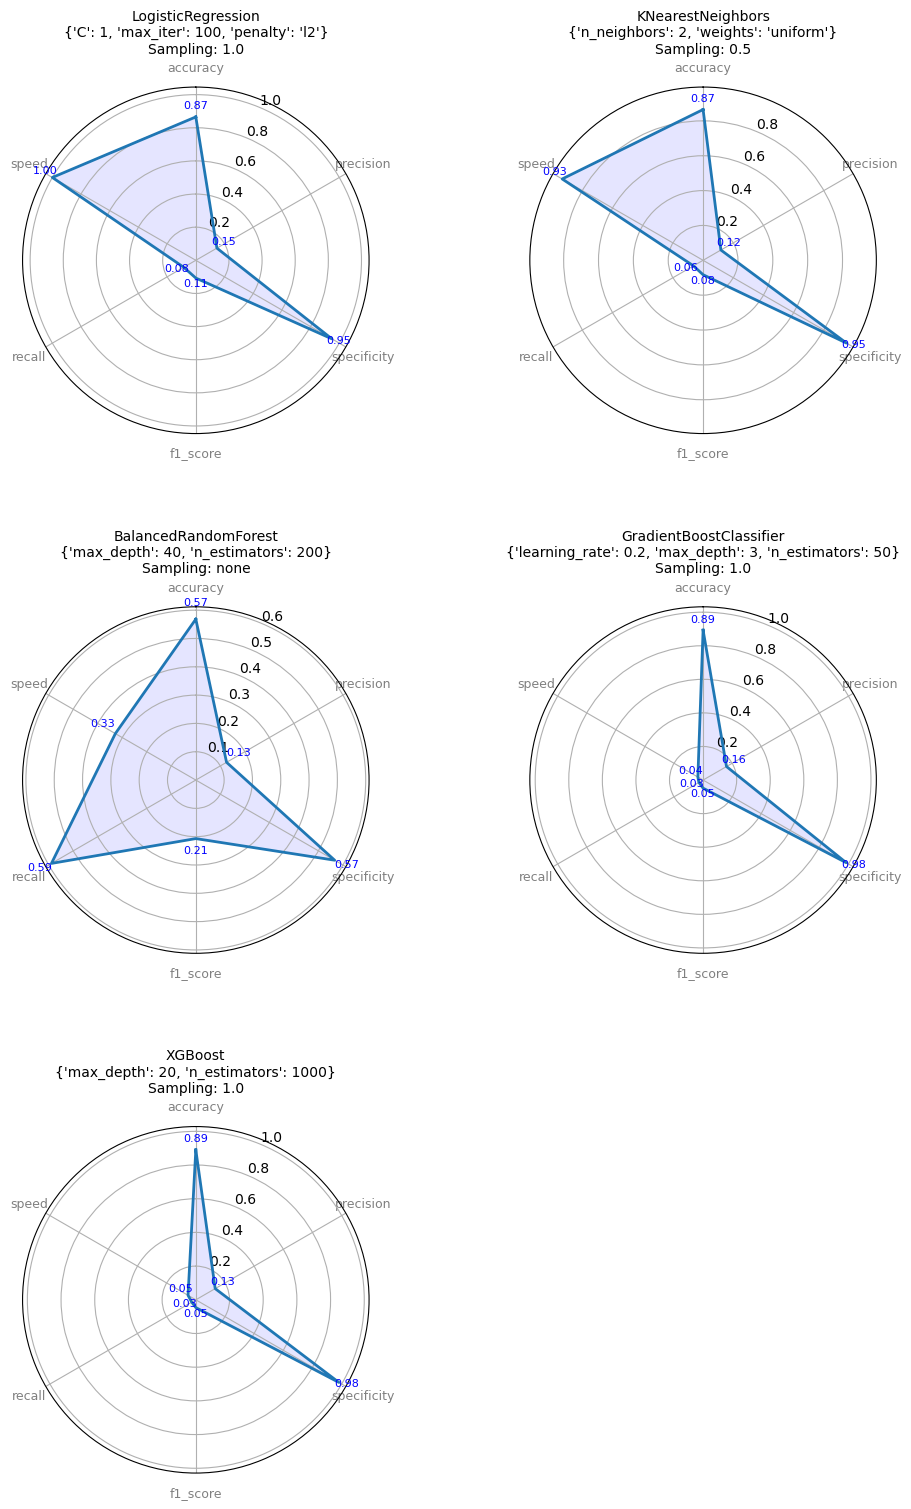

In [213]:
# Definir métricas y calcular 'speed' en el DataFrame
metrics = ['accuracy', 'precision', 'specificity', 'f1_score', 'recall', 'speed']
metrics_df['speed'] = metrics_df['avg_training_time'].min() / metrics_df['avg_training_time']

# Función para crear el gráfico de radar
def plot_radar(ax, data, title):
    num_vars = len(metrics)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Para cerrar el gráfico

    # Configurar los ejes y las etiquetas
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # Valores para el radar y cierre del gráfico en el primer punto
    values = data[metrics].values.flatten().tolist()
    values += values[:1]
    
    # Etiquetas para cada métrica alrededor del gráfico
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, fontsize=9, color="grey")
    
    # Plotear y rellenar
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.1)

    # Añadir valores dentro del gráfico
    for i in range(num_vars):
        ax.text(angles[i], values[i] + 0.05, f'{values[i]:.2f}', horizontalalignment='center', size=8, color='blue')

    
    # Añadir título y ajustar líneas
    ax.set_title("\n".join(title), fontsize=10)

# Configuración de los subplots en una cuadrícula de 3 columnas
num_models = len(metrics_df)
num_cols = 2
num_rows = (num_models + num_cols - 1) // num_cols

fig, axs = pyp.subplots(num_rows, num_cols, figsize=(12, num_rows * 6), subplot_kw=dict(polar=True))
pyp.subplots_adjust(hspace=0.5)

# Asegurarse de que axs sea siempre un array 2D
if num_rows == 1:
    axs = np.expand_dims(axs, axis=0)
elif num_cols == 1:
    axs = np.expand_dims(axs, axis=1)

# Iterar sobre cada modelo en el DataFrame
for idx, row in metrics_df.iterrows():
    row_idx, col_idx = divmod(idx, num_cols)
    title = [
        f"{row['model']}",
        f"{row['optimal_params']}",
        f"Sampling: {row['sampling_strategy']}"
    ]
    plot_radar(axs[row_idx, col_idx], row, title)

# Eliminar subplots vacíos si hay menos modelos que subplots
for idx in range(num_models, num_rows * num_cols):
    fig.delaxes(axs.flatten()[idx])

pyp.show()


## Conclusiones
El presente análisis no ha sido capaz de encontrar un modelo que pueda predecir de manera aceptable si un usuario responderá positivamente a la campaña de marketing vía Direct Mail por lo que se hacen las siguientes recomendaciones:
  - **Ampliar la fuente de datos**: El dataset contiene correlaciones muy débiles entre las variables independientes y objetivo. Además está muy desbalanceado, de forma tal que es difícil encontrar patrones que sugieran cuándo el cliente responderá positivamente y cuando no. Sería ideal contar con más datos obtenidos por la empresa en cuestión y, mucho mejor, si se tuvieran más variables independiente tal vez con correlaciones más fuertes con la variable objetivo.
  - **Explorar otras formas de sobremuestreo**: El ovesampling con SMOTE no dio los resultados esperados pero puede haber otras técnicas de sobremuestreo que se pueden explorar para compensar el desbalance en el dataset.
  - **Explorar otros modelos de clasificación**: Ninguno de los modelos evaluados obtuvo un rendimiento aceptable en términos de predicción por lo que se recomienda explorar más modelos.